In [16]:
# Import libraries
import numpy as np                          # Numerical arrays
import os                                  # File and directory handling
import cv2                                 # Image processing
import matplotlib.pyplot as plt             # Plotting and visualization
from PIL import Image                      # Image loading
from tensorflow.keras.utils import to_categorical  # One-hot encoding
from tensorflow.keras.models import Sequential     # Sequential CNN model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout  # CNN layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Data augmentation


In [17]:
# Dataset path
data_dir = "C:\\Users\\peesa\\OneDrive\\Documents\\Desktop\\Project\\archive\\Vehicle\\train"  # Root training directory

# Define classes
classes = ["Cars", "Motorcycles", "Trains"]   # Class folder names
img_size = 128                                # Target image size

# Load and preprocess images
X, y = [], []                                 # Feature and label lists
for idx, category in enumerate(classes):      # Loop over classes with index
    folder = os.path.join(data_dir, category) # Build class folder path
    for file in os.listdir(folder):           # Iterate through images
        img_path = os.path.join(folder, file) # Full image path
        img = Image.open(img_path).convert("RGB")  # Load image as RGB
        img = np.array(img)                   # Convert to NumPy array
        if img is not None:                   # Safety check
            img = cv2.resize(img, (img_size, img_size))  # Resize image
            X.append(img)                     # Store image
            y.append(idx)                     # Store label

X = np.array(X) / 255.0                       # Normalize pixel values
y = to_categorical(np.array(y), num_classes=len(classes))  # One-hot encode labels

print("Total samples:", X.shape[0])           # Print dataset size

Total samples: 1673


In [18]:
# Train / Validation split (80/20) - based on the random shuffle
np.random.seed(0)                     # Fix seed for reproducibility

indices = np.arange(len(X))           # Create index array
np.random.shuffle(indices)            # Randomly shuffle indices

split_ratio = 0.8                     # 80% training data
split_index = int(len(X) * split_ratio)  # Compute split point

train_idx = indices[:split_index]     # Training indices
val_idx = indices[split_index:]       # Validation indices

X_train, X_val = X[train_idx], X[val_idx]  # Split feature data
y_train, y_val = y[train_idx], y[val_idx]  # Split label data

print("Training samples:", X_train.shape[0])     # Training set size
print("Validation samples:", X_val.shape[0])     # Validation set size

Training samples: 1338
Validation samples: 335


In [19]:
# Data augmentation
datagen = ImageDataGenerator(        # Create data augmentation generator
    rotation_range=20,               # Random rotations (degrees)
    width_shift_range=0.1,            # Horizontal shift
    height_shift_range=0.1,           # Vertical shift
    zoom_range=0.2,                   # Random zoom
    horizontal_flip=True              # Random horizontal flip
)
datagen.fit(X_train)                 # Fit generator to training data

In [20]:
# Build CNN model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_size, img_size, 3)),  # Conv layer (32 filters)
    MaxPooling2D(2,2),                                                          # Downsampling
    Conv2D(64, (3,3), activation='relu'),                                       # Conv layer (64 filters)
    MaxPooling2D(2,2),                                                          # Downsampling
    Conv2D(128, (3,3), activation='relu'),                                      # Conv layer (128 filters)
    MaxPooling2D(2,2),                                                          # Downsampling
    Flatten(),                                                                  # Convert to 1D vector
    Dense(128, activation='relu'),                                              # Fully connected layer
    Dropout(0.5),                                                               # Reduce overfitting
    Dense(len(classes), activation='softmax')                                   # Output layer
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  # Compile model


In [21]:
# Train model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),  # Augmented training batches
    validation_data=(X_val, y_val),                  # Validation dataset
    epochs=15                                        # Number of training epochs
)

Epoch 1/15
42/42 [==============================] - 8s 166ms/step - loss: 1.0462 - accuracy: 0.4357 - val_loss: 0.8739 - val_accuracy: 0.5910
Epoch 2/15
42/42 [==============================] - 7s 154ms/step - loss: 0.8917 - accuracy: 0.5725 - val_loss: 0.7671 - val_accuracy: 0.6657
Epoch 3/15
42/42 [==============================] - 6s 152ms/step - loss: 0.7871 - accuracy: 0.6734 - val_loss: 0.5792 - val_accuracy: 0.8149
Epoch 4/15
42/42 [==============================] - 7s 154ms/step - loss: 0.6968 - accuracy: 0.7302 - val_loss: 0.5292 - val_accuracy: 0.7881
Epoch 5/15
42/42 [==============================] - 7s 155ms/step - loss: 0.6289 - accuracy: 0.7549 - val_loss: 0.5245 - val_accuracy: 0.7761
Epoch 6/15
42/42 [==============================] - 7s 153ms/step - loss: 0.6180 - accuracy: 0.7743 - val_loss: 0.6026 - val_accuracy: 0.7761
Epoch 7/15
42/42 [==============================] - 6s 153ms/step - loss: 0.5716 - accuracy: 0.7788 - val_loss: 0.3740 - val_accuracy: 0.8597
Epoch 

In [22]:
# Evaluate model
val_loss, val_acc = model.evaluate(X_val, y_val)   # Evaluate on validation data
print(f"Validation Accuracy: {val_acc:.2f}")       # Print validation accuracy

model.summary()                                    # Display model architecture

11/11 [==============================] - 0s 34ms/step - loss: 0.2473 - accuracy: 0.9104
Validation Accuracy: 0.91
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 128)       73856     
      

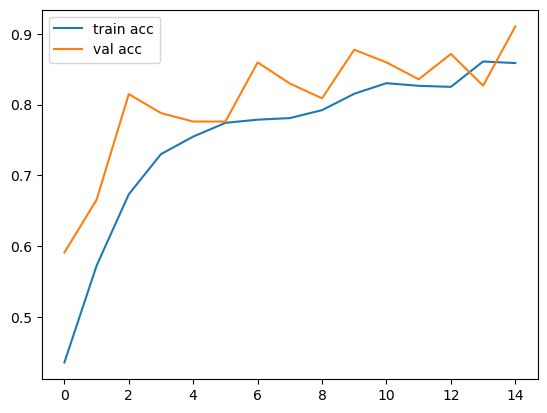

In [23]:
# Plot training history
plt.plot(history.history['accuracy'], label='train acc')     # Training accuracy curve
plt.plot(history.history['val_accuracy'], label='val acc')  # Validation accuracy curve
plt.legend()                                                 # Show legend
plt.show()                                                   # Display plot

In [24]:
# test the model on test dataset
import numpy as np                          # Numerical operations
import cv2                                 # Image processing
import os                                  # File and directory handling
import matplotlib.pyplot as plt             # Visualization (optional use)
from PIL import Image                      # Image loading
from tensorflow.keras.utils import to_categorical  # One-hot encoding

test_dir = "C:\\Users\\peesa\\OneDrive\\Documents\\Desktop\\Project\\archive\\Vehicle\\test"  # Test dataset path

test_images = []                           # Store test images
test_labels = []                           # Store test labels
test_files = []                            # Store test filenames

for idx, category in enumerate(classes):   # Loop over test classes
    folder = os.path.join(test_dir, category)  # Class folder path
    for file in os.listdir(folder):        # Iterate through test images
        img_path = os.path.join(folder, file)  # Full image path
        img = Image.open(img_path).convert("RGB")  # Load image as RGB
        img = np.array(img)                # Convert to NumPy array
        if img is not None:                # Safety check
            img = cv2.resize(img, (img_size, img_size))  # Resize image
            test_images.append(img)        # Store image
            test_labels.append(idx)        # Store label
            test_files.append(file)        # Store filename

X_test = np.array(test_images, dtype=np.float32) / 255.0  # Normalize test images
y_test = to_categorical(np.array(test_labels), num_classes=len(classes))  # One-hot labels

print("Total test samples:", X_test.shape[0])  # Print test set size


Total test samples: 359


12/12 [==============================] - 0s 33ms/step

Test Accuracy: 0.8942

Confusion Matrix:
[[107   2  10]
 [  5 104  11]
 [  7   3 110]]

Classification Report:
Class            Precision     Recall   F1-score    Support
Cars                0.8992     0.8992     0.8992        119
Motorcycles         0.9541     0.8667     0.9083        120
Trains              0.8397     0.9167     0.8765        120

Showing random test samples:



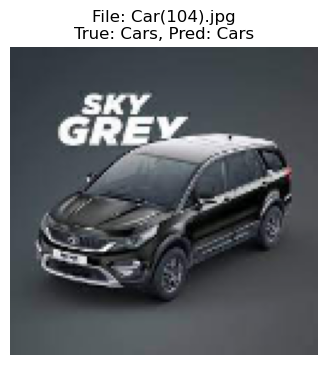

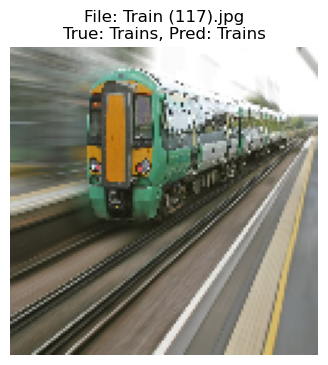

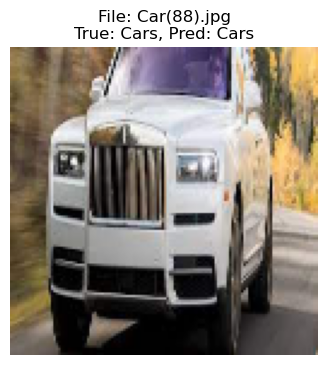

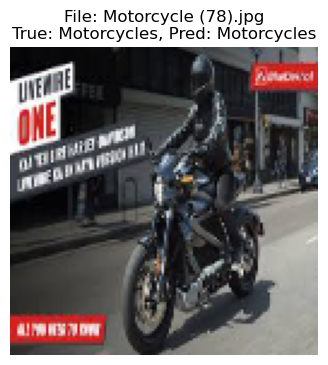

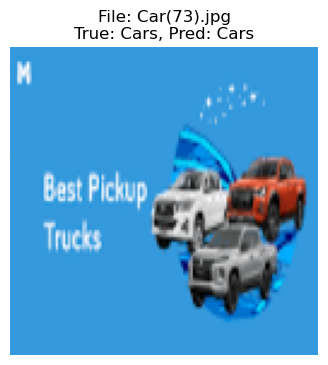

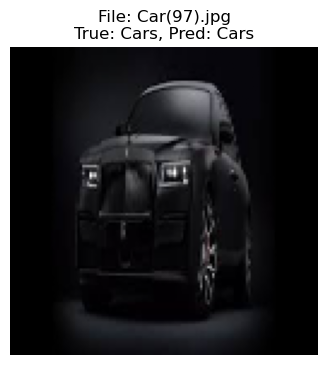

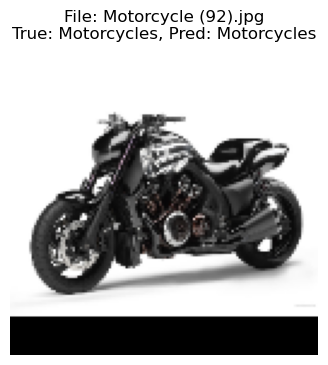

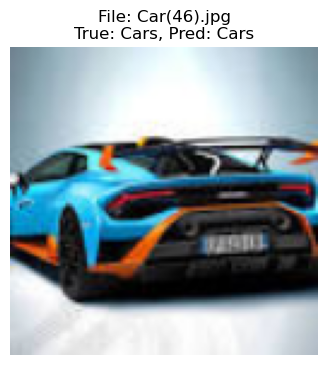

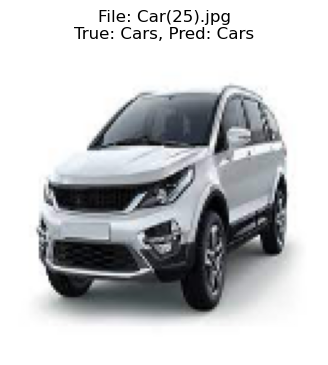

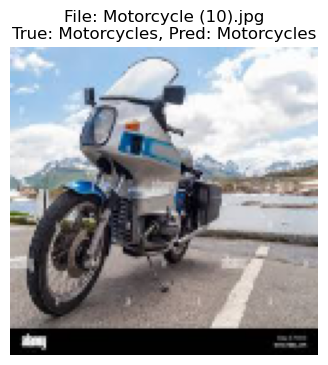

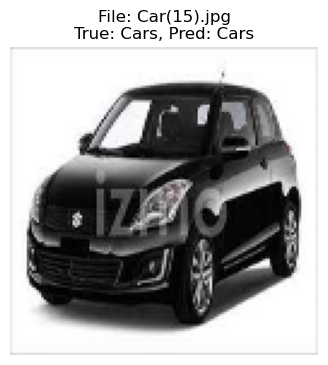

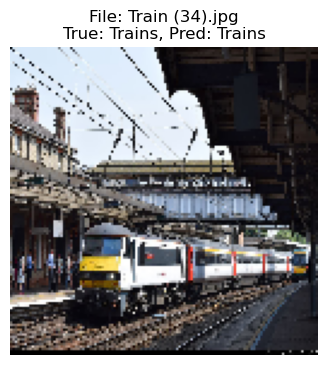

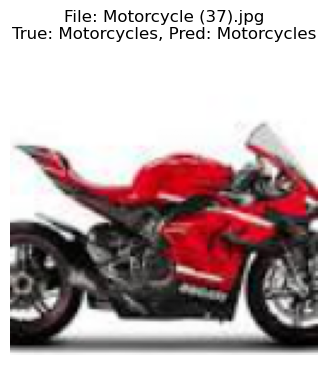

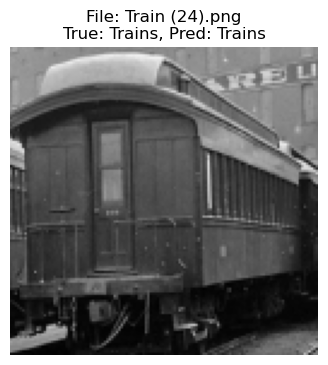

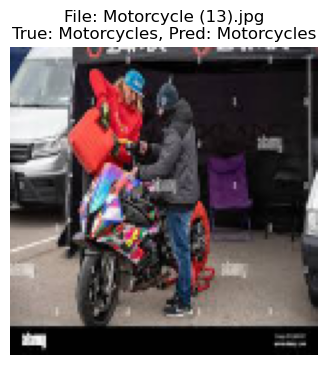

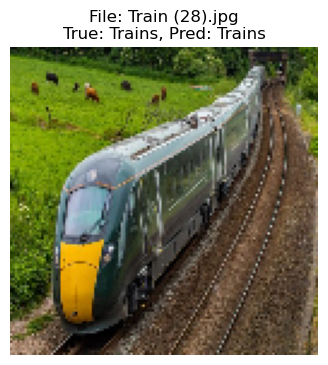

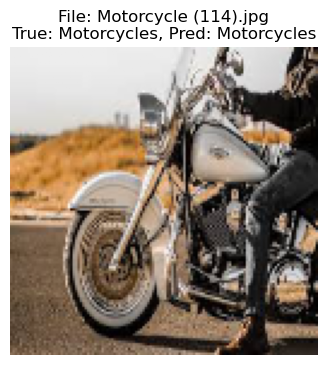

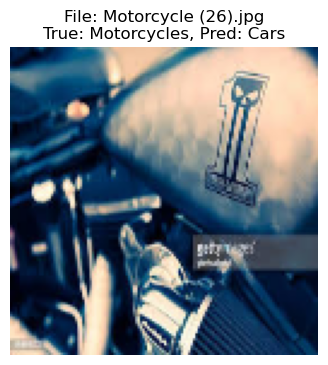

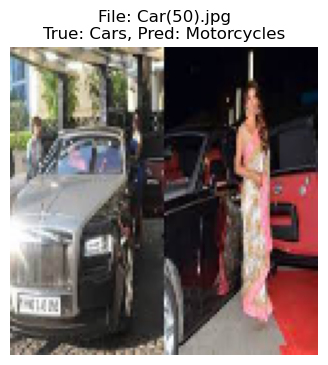

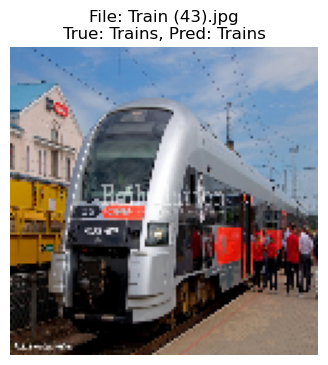

In [25]:
pred_probs = model.predict(X_test)                 # Predict class probabilities
pred_classes = np.argmax(pred_probs, axis=1)       # Predicted class indices
true_classes = np.argmax(y_test, axis=1)           # True class indices


accuracy = np.mean(pred_classes == true_classes)   # Compute test accuracy
print(f"\nTest Accuracy: {accuracy:.4f}")           # Print test accuracy

# Confusion Matrix

num_classes = len(classes)                          # Number of classes
conf_matrix = np.zeros((num_classes, num_classes), dtype=int)  # Initialize matrix

for t, p in zip(true_classes, pred_classes):        # Iterate true vs predicted
    conf_matrix[t, p] += 1                          # Update confusion matrix

print("\nConfusion Matrix:")
print(conf_matrix)                                  # Display confusion matrix

# Classification Report

print("\nClassification Report:")
print(f"{'Class':15s} {'Precision':>10s} {'Recall':>10s} {'F1-score':>10s} {'Support':>10s}")

for i, class_name in enumerate(classes):            # Loop through each class
    TP = conf_matrix[i, i]                          # True positives
    FP = conf_matrix[:, i].sum() - TP               # False positives
    FN = conf_matrix[i, :].sum() - TP               # False negatives

    precision = TP / (TP + FP + 1e-8)               # Precision metric
    recall = TP / (TP + FN + 1e-8)                  # Recall metric
    f1 = 2 * precision * recall / (precision + recall + 1e-8)  # F1-score
    support = conf_matrix[i, :].sum()               # Class support

    print(f"{class_name:15s} {precision:10.4f} {recall:10.4f} {f1:10.4f} {support:10d}")

# --------------------------------------------------
# Randomly choose test images for visualization
# --------------------------------------------------
np.random.seed(0)                                   # Fix seed for reproducibility
num_show = 20                                       # Number of images to display
random_indices = np.random.choice(len(X_test), size=num_show, replace=False)  # Random indices

print("\nShowing random test samples:\n")

for i in random_indices:                            # Loop over selected images
    plt.figure(figsize=(4,4))                       # Create figure
    plt.imshow(X_test[i])                           # Display image
    plt.title(                                      # Show filename and predictions
        f"File: {test_files[i]}\n"
        f"True: {classes[true_classes[i]]}, "
        f"Pred: {classes[pred_classes[i]]}"
    )
    plt.axis("off")                                 # Hide axes
    plt.show()                                      # Render plot


In [29]:
import matplotlib.patches as patches

def plot_workflow_figure(save_path=None):
    fig, ax = plt.subplots(figsize=(12, 2.8))
    ax.axis("off")

    blocks = [
        "Input Image",
        "Preprocessing\n(resize + normalize)",
        "CNN Feature Extraction\n(Conv + Pool)",
        "Dense Classification\n(Dense + Dropout)",
        "Output Class\n(Softmax)"
    ]

    x0, y0 = 0.02, 0.25
    w, h = 0.18, 0.5
    gap = 0.02

    for i, label in enumerate(blocks):
        x = x0 + i * (w + gap)
        rect = patches.FancyBboxPatch(
            (x, y0), w, h,
            boxstyle="round,pad=0.02,rounding_size=0.03",
            linewidth=1
        )
        ax.add_patch(rect)
        ax.text(x + w/2, y0 + h/2, label, ha="center", va="center", fontsize=10)

        if i < len(blocks) - 1:
            ax.annotate(
                "", xy=(x + w + gap*0.2, y0 + h/2), xytext=(x + w, y0 + h/2),
                arrowprops=dict(arrowstyle="->", linewidth=1.2)
            )

    ax.set_title("Figure 1. Overview of the Vehicle Classification Pipeline", pad=10)

    if save_path:
        savefig(save_path)
    plt.show()
